In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import Cell_BLAST as cb
import exputils
cb.config.RANDOM_SEED = 0
cb.config.N_JOBS = 8
random_state = np.random.RandomState(0)

In [2]:
def pred_report(pred, true, positive_labels):
    true_positive_mask = np.in1d(true, positive_labels)
    pred_positive_mask = ~np.in1d(pred, ["rejected"])
    sensitivity = np.logical_and(true_positive_mask, pred_positive_mask).sum() / true_positive_mask.sum()
    specificity = np.logical_and(~true_positive_mask, ~pred_positive_mask).sum() / (~true_positive_mask).sum()
    positive_mask = np.logical_and(true_positive_mask, pred_positive_mask)
    kappa = sklearn.metrics.cohen_kappa_score(true[positive_mask], pred[positive_mask])
    acc = (true[positive_mask] == pred[positive_mask]).sum() / positive_mask.sum()
    return acc, kappa, specificity, sensitivity

# Read data

### Reference

In [3]:
ref = cb.data.ExprDataSet.merge_datasets(dict(
    baron=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Baron_human/data.h5"),
    xin=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Xin_2016/data.h5"),
    lawlor=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Lawlor/data.h5")
), merge_uns_slots=["seurat_genes"]).normalize()
ref = ref[:, ref.uns["seurat_genes"]]
ref = exputils.clean_dataset(ref, "cell_ontology_class")

[ Warning ] 20984 out of 41109 variables are not found, will be set to zero!
[ Warning ] 1258 out of 41109 variables are not found, will be set to zero!
[ Warning ] 21224 out of 41109 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...


/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/Cell_BLAST/data.py:579: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  merged_obs = pd.concat(merged_obs)


[  Info   ] Cleaning removed 0 cells.


### Query

In [4]:
query = dict(
    # Positive
    segerstolpe=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Segerstolpe/data.h5"),
    enge=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Enge/data.h5"),
    muraro=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Muraro/data.h5"),
    # Negative
    young=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Young/data.h5"),
    wu_human=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Wu_human/data.h5"),
    zheng=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Zheng/data.h5"),
    philippeos=cb.data.ExprDataSet.read_dataset("../../Datasets/data/Philippeos/data.h5")
)

min_size = max(min(val.shape[0] for val in query.values()), 2000)
query = cb.data.ExprDataSet.merge_datasets({
    key: val.normalize()[
        random_state.choice(val.shape[0], min(min_size, val.shape[0]), replace=False),
        ref.var_names
    ] for key, val in query.items()
})
query = exputils.clean_dataset(query, "cell_ontology_class")

[ Warning ] 1 out of 1751 variables are not found, will be set to zero!
[ Warning ] 40 out of 1751 variables are not found, will be set to zero!
[ Warning ] 16 out of 1751 variables are not found, will be set to zero!
[ Warning ] 4 out of 1751 variables are not found, will be set to zero!
[ Warning ] 246 out of 1751 variables are not found, will be set to zero!
[  Info   ] Merging uns slots...
[  Info   ] Merging var data frame...
[  Info   ] Merging obs data frame...
[  Info   ] Merging expression matrix...
[  Info   ] Cleaning removed 0 cells.


# Train models

In [5]:
models = []
for i in range(128):
    print("==== Model: %d ====" % i)
    model = cb.directi.fit_DIRECTi(
        ref, ref.uns["seurat_genes"], batch_effect="dataset_name",
        latent_dim=10, cat_dim=20, epoch=300, patience=20,
        random_seed=i, path="./n_models/model_%d" % i
    )
    model.save()
    models.append(model)

==== Model: 0 ====
[DIRECTi epoch 0] train=1.924, val=1.931, time elapsed=2.3s Regular save...
[DIRECTi epoch 1] train=1.882, val=1.800, time elapsed=1.1s
[DIRECTi epoch 2] train=1.105, val=0.772, time elapsed=1.1s
[DIRECTi epoch 3] train=0.666, val=0.693, time elapsed=1.1s
[DIRECTi epoch 4] train=0.644, val=0.657, time elapsed=1.1s
[DIRECTi epoch 5] train=0.639, val=0.656, time elapsed=1.1s
[DIRECTi epoch 6] train=0.633, val=0.637, time elapsed=1.1s
[DIRECTi epoch 7] train=0.626, val=0.630, time elapsed=1.1s
[DIRECTi epoch 8] train=0.620, val=0.622, time elapsed=1.0s
[DIRECTi epoch 9] train=0.615, val=0.623, time elapsed=1.0s
[DIRECTi epoch 10] train=0.612, val=0.623, time elapsed=1.1s Regular save...
[DIRECTi epoch 11] train=0.608, val=0.618, time elapsed=1.1s
[DIRECTi epoch 12] train=0.604, val=0.609, time elapsed=1.1s
[DIRECTi epoch 13] train=0.597, val=0.604, time elapsed=1.1s
[DIRECTi epoch 14] train=0.591, val=0.596, time elapsed=1.1s
[DIRECTi epoch 15] train=0.588, val=0.591, t

In [6]:
# models = []
# for i in range(128):
#     print("==== Model: %d ====" % i)
#     models.append(cb.directi.DIRECTi.load("./n_models/model_%d" % i, _mode=cb.directi.DIRECTi._TEST))

# Test BLAST with different number of models

In [7]:
np.random.seed(0)
hits_dict = {}
for n_model in (1, 2, 4, 8, 16):
    print("==== Number of models: %d ====" % n_model)
    hits_dict[n_model] = []
    available_models = np.arange(128)
    for trial in range(8):
        used_models = np.random.choice(available_models, n_model, replace=False)
        available_models = np.setdiff1d(available_models, used_models)
        blast = cb.blast.BLAST([models[idx] for idx in used_models], ref).build_empirical()
        hits_dict[n_model].append(blast.query(query))

==== Number of models: 1 ====
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest neighbor search...
[  Info   ] Merging hits across models...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Computing empirical p-values...
[  Info   ] Projecting to latent space...
[  Info   ] Fitting nearest neighbor trees...
[  Info   ] Computing posterior distribution distances...
[  Info   ] Projecting to latent space...
[  Info   ] Doing nearest ne

In [8]:
pred_dict = {}
for n_model in hits_dict.keys():
    pred_dict[n_model] = []
    for hits in hits_dict[n_model]:
        pred = hits.reconcile_models().filter(
            "pval", 0.05
        ).annotate("cell_ontology_class", min_hits=2)["cell_ontology_class"]
        pred_dict[n_model].append(pred)

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [9]:
report_df = [(key, *pred_report(
    pred_dict[key][i].values, query.obs["cell_ontology_class"], np.unique(ref.obs["cell_ontology_class"])
)) for key in pred_dict.keys() for i in range(len(pred_dict[key]))]
report_df = [*zip(*report_df)]
report_df = pd.DataFrame({
    "Number of models": report_df[0],
    "Accuracy": report_df[1],
    "Kappa": report_df[2],
    "Specificity": report_df[3],
    "Sensitivity": report_df[4]
}).melt(id_vars="Number of models", var_name="Metric", value_name="Value")
report_df.to_csv("./n_models.csv")

/home/caozj/Software/anaconda2/envs/cb-gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


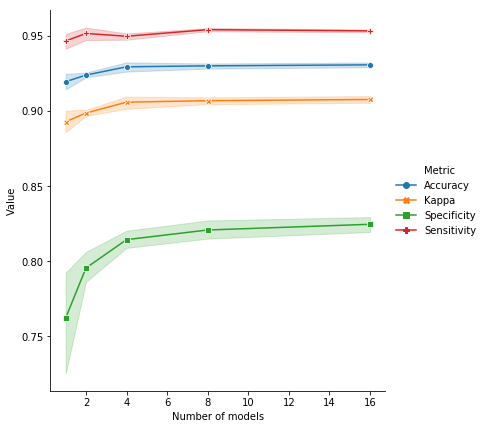

In [10]:
report_df = pd.read_csv("./n_models.csv")
fig, ax = plt.subplots(figsize=(6, 7))
ax = sns.lineplot(
    x="Number of models", y="Value", hue="Metric", style="Metric",
    markers=True, dashes=False, data=report_df, ax=ax
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0, frameon=False)
fig.savefig("./n_models.pdf", bbox_inches="tight")